In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from spectral_cube import SpectralCube
import regions
from NOEMAsetup import *
# Use only with regions!

### Important functions

In [2]:
def degtohoursRA(deg):
    hours = deg / 360 * 24
    hh = np.trunc(hours).astype('int64')

    minutes = ((hours-hh) % 60) * 60
    mm = np.trunc(minutes).astype('int64')
    seconds = ((minutes-mm) % 60) * 60
    ss = np.round(seconds, 2)
    return '{0:02d}:{1:02d}:{2:0>5}'.format(hh, mm, ss)


def degtohoursDEC(deg):
    dd = np.trunc(deg).astype('int64')
    minutes = ((np.abs(deg)-np.abs(dd)) % 60) * 60
    mm = np.trunc(minutes).astype('int64')
    seconds = ((minutes-mm) % 60) * 60
    ss = np.round(seconds, 2)
    return '{0:02d}:{1:02d}:{2:0>5}'.format(dd, mm, ss)


def plotSpectra(ax, vel, spec, color='k', freq=None, beamarea=None, xlims=None, ylims=None):
    if kelvin:
        spec = spec.to(u.K, u.brightness_temperature(freq, beam_area=beamarea))
    ax.plot(vel, spec, drawstyle='steps-mid', color=color)
    ax.set_xlabel('Velocity (km/s)')
    if kelvin:
        ax.set_ylabel('Intensity (K)')
    else:
        ax.set_ylabel('Intensity (Jy/beam)')

    if xlims is not None:
        ax.set_xlim(xlims)
    if ylims is not None:
        ax.set_ylim(ylims)
    return ax


def plotSpectras(fig, position, fitsfiles, labels, colors, regionlabel, phasecenter, subplots=111, xlims=None, ylims=None, saving=False, specname=''):
    deltas = phasecent-position
    ax = fig.add_subplot(subplots)
    i = 0
    for fitsfile, label, color in zip(fitsfiles, labels,  colors):
        if fitsfile is None:
            continue
        cube = SpectralCube.read(fitsfile+'.fits')
        cube = cube.with_spectral_unit(u.km/u.s)
        cube = cube.spectral_slab(velstart*u.km/u.s, velend*u.km/u.s)
        # cube = fits.getdata(fitsfile+'.fits')
        cubehead = fits.getheader(fitsfile+'.fits')
        bmaj = cubehead['bmaj'] * u.deg
        bmin = cubehead['bmin'] * u.deg
        beamarea = (1.133 * bmaj * bmin).to(u.arcsec**2)
        restfreq = cubehead['restfreq'] * u.Hz
        cubewcs = WCS(cubehead)
        ra, dec = cubewcs.celestial.all_world2pix(position[0], position[1], 0)
        rah = degtohoursRA(position[0])
        dech = degtohoursDEC(position[1])
        velocities = cube.spectral_axis
        spectra = cube[:, int(dec), int(ra)]
        if kelvin:
            ax = plotSpectra(ax, velocities, spectra, color=color, freq=restfreq, beamarea=beamarea, xlims=xlims, ylims=ylims)
        else:
            ax = plotSpectra(ax, velocities, spectra, color=color, xlims=xlims, ylims=ylims)
        ax.text(0.05, 0.9-0.09*i, label, horizontalalignment='left', transform=ax.transAxes, color=color, size=14)
        i += 1
    ax.text(0.05, 0.9-0.09*i, 'Region '+regionlabel, horizontalalignment='left', transform=ax.transAxes, color='k', size=14)
    if saving:
        fig.savefig(fitsfiles[0]+'_delta_'+str(np.round(deltas[0]*3600, 2))+'_' + str(
            np.round(-deltas[1]*3600, 2))+'_'+specname+'.png', bbox_inches='tight')


## Spectra with one line

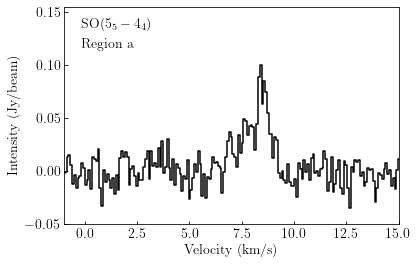

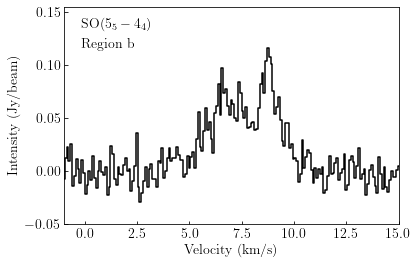

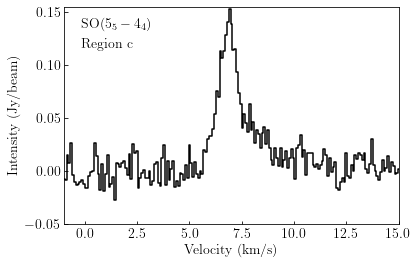

In [3]:
saveaction = 0
kelvin = 0
namecomparison = 'SO_auxregions'
label1 = r'SO($5_5 - 4_4$)'

folder = 'SO_55_44/CDconfig/'
fitsfile = SO_55_44

regfile = folder+'spectra_aux_reg2.reg'
fitsfilelist = [fitsfile]
labellist = [label1]
colorlist = ['k']

velstart = -1
velend = 15

intmin = -0.05
intmax = 0.155 # Jy.beam
# intmin = -5
# intmax = 30 # K

header = fits.getheader(fitsfile+'.fits')
phasecent = np.array([header['ra'], header['dec']])
regionload = regions.read_ds9(regfile)
positions = [[regionload[i].center.ra.value, regionload[i].center.dec.value]
             for i in range(len(regionload))]
regionlabels = [regionload[i].meta['label'] for i in range(len(regionload))]


for position, regionlabel in zip(positions, regionlabels):
    '''
    For each region in the list, plot
    '''
    fig = plt.figure(figsize=(6,4))
    plotSpectras(fig, position, fitsfilelist, labellist, colorlist, regionlabel, phasecent,
                 xlims=[velstart, velend], ylims=[intmin, intmax], saving=saveaction, specname=namecomparison+'_reg'+regionlabel)
    plt.show()


## Spectra with two lines

H2CO v/s SO(55-44)

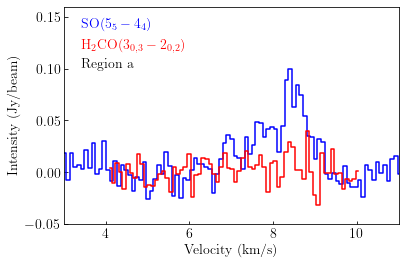

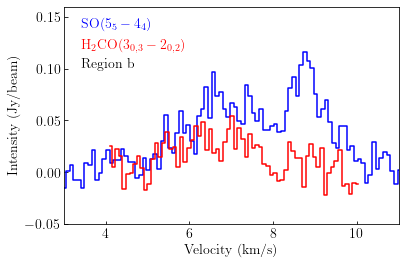

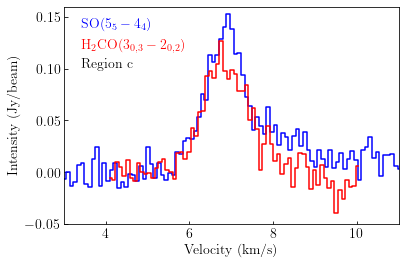

In [4]:
saveaction = 0
kelvin = 0
namecomparison = 'H2CO_SO5544'
label1 = r'SO($5_5 - 4_4$)'
label2 = r'H$_2$CO($3_{0,3} - 2_{0,2}$)'

folder = 'SO_55_44/CDconfig/'
fitsfile = SO_55_44_s
fitsfile2 = H2CO_303_202_s

regfile = folder+'spectra_aux_reg2.reg'
fitsfilelist = [fitsfile, fitsfile2]
labellist = [label1, label2]
colorlist = ['b', 'r']

velstart = 3
velend = 11

intmin = -0.05
intmax = 0.16 # Jy.beam
# intmin = -5
# intmax = 30 # K

header = fits.getheader(fitsfile+'.fits')
phasecent = np.array([header['ra'], header['dec']])
regionload = regions.read_ds9(regfile)
positions = [[regionload[i].center.ra.value, regionload[i].center.dec.value]
             for i in range(len(regionload))]
regionlabels = [regionload[i].meta['label'] for i in range(len(regionload))]


for position, regionlabel in zip(positions, regionlabels):
    '''
    For each region in the list, plot
    '''
    fig = plt.figure(figsize=(6,4))
    plotSpectras(fig, position, fitsfilelist, labellist, colorlist, regionlabel, phasecent,
                 xlims=[velstart, velend], ylims=[intmin, intmax], saving=saveaction, specname=namecomparison+'_reg'+regionlabel)
    plt.show()
